In [1]:
import pandas as pd
import numpy as np
import matplotlib
import math
import scipy.stats as stats

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../data/Bubble-Cursor(Responses).csv')

In [3]:
CursorType = df.groupby(['Cursor'])['Time(ms)'].mean().to_frame(name=None).reset_index()

In [4]:
EffectiveWidth = df.groupby(['eww', 'Cursor'])['Time(ms)'].mean().to_frame(name=None).reset_index()

In [5]:
Amplitude = df.groupby(['A', 'Cursor'])['Time(ms)'].mean().to_frame(name=None).reset_index()

In [6]:
Width = df.groupby(['w', 'Cursor'])['Time(ms)'].mean().to_frame(name=None).reset_index()

In [7]:
TotalDensity = df.groupby(['Total-Density', 'Cursor'])['Time(ms)'].mean().to_frame(name=None).reset_index()

In [8]:
DistractorDensity = df.groupby(['Distractors', 'Cursor'])['Time(ms)'].mean().to_frame(name=None).reset_index()

### Calculating index of difficulty

In [9]:
def bubblecursor(row):
    return round(math.log(row['A']/(row['eww'] * row['w']) + 1), 2)

def normalcursor(row):
    return round(math.log(row['A']/row['w'] + 1), 2)

for index, row in df.iterrows():
    if(row['Cursor'] == 'normal'):
        df.loc[index,'ID'] = normalcursor(row)
    else:
        df.loc[index, 'ID'] = bubblecursor(row)
# df['ID'] = df.Cursor.apply(
#                lambda x: (rowFunc if x == 'bubble' else -1))

In [10]:
ID = df.groupby(['ID', 'Cursor'])['Time(ms)'].mean().to_frame(name=None).reset_index()

In [11]:
def plot(p_df, string, x, y, xlabel, ylabel, xlimit):
    plt.style.use('ggplot');
    fig, ax = plt.subplots(figsize=(8,6))
    # https://matplotlib.org/api/markers_api.html
    styles = ['x--', 'o--']
    linewidths = [1, 2]
    i = 0;
    for label, e in p_df.groupby('Cursor'):
        e.plot(x=x, y=y, kind="line", ax=ax, label=label, style=styles[i], linewidth=linewidths[i])
        i += 1
    ax.set_title('%s\n'% string)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_xlim(xlimit[0], xlimit[1])
    legend = ax.legend(loc="upper right", fontsize=12, edgecolor="black", facecolor="white")
#     bbox_to_anchor=(1,1),
    for text in legend.get_texts():
        plt.setp(text, color = 'black')

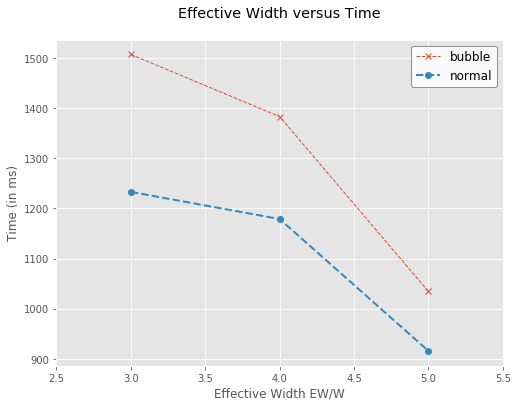

In [12]:
plot(EffectiveWidth, 'Effective Width versus Time', 'eww', 'Time(ms)', 'Effective Width EW/W', 'Time (in ms)', [2.5, 5.5])

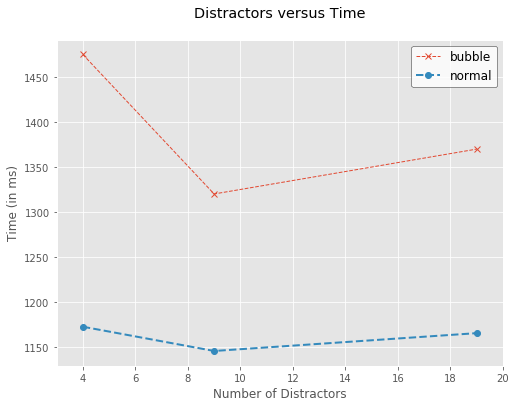

In [13]:
plot(DistractorDensity, 'Distractors versus Time', 'Distractors', 'Time(ms)', 'Number of Distractors', 'Time (in ms)', [3, 20])

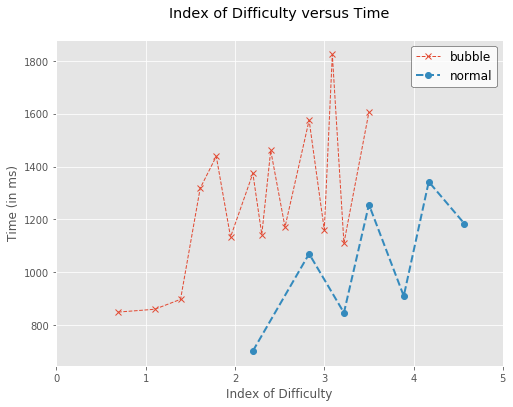

In [14]:
plot(ID, 'Index of Difficulty versus Time', 'ID', 'Time(ms)', 'Index of Difficulty', 'Time (in ms)', [0, 5])

Seems to me that there might be some noise in the data I collected. The way that I implement the experiment is different from that in the paper. Perhaps the start button is causing some issues. Additionally, I am not generating eww in the same way as the paper is - it is handled by padding. But since the circles are randomized, it is not necessary that there are 4 circles around the target at all times.

I am not convinced that bubble cursor is actually faster. When I spoke to my users, they found bubble cursor to be really inconvenient. 

# Now on to the ANOVA test

## A. One way ANOVA

In [15]:
def getArray(df, colname, colval, col2name):
    return df.loc[df[colname] == colval][col2name].as_matrix()

### 1. Cursor Type

In [16]:
#stats.f_oneway(df.)
bubbleTime = getArray(df, 'Cursor', 'bubble', 'Time(ms)')
normalTime = getArray(df, 'Cursor', 'normal', 'Time(ms)')
stats.f_oneway(bubbleTime, normalTime)

F_onewayResult(statistic=25.538320390676983, pvalue=5.3830535538069212e-07)

Means it is slightly statistically significant with a low probability of chance

### 2. EW/W

In [17]:
EffectiveWidth['eww'].unique()

array([3, 4, 5])

In [18]:
ew3 = getArray(df, 'eww', 3, 'Time(ms)')
ew4 = getArray(df, 'eww', 4, 'Time(ms)')
ew5 = getArray(df, 'eww', 5, 'Time(ms)')
stats.f_oneway(ew3, ew4, ew5)

F_onewayResult(statistic=17.135944950638223, pvalue=5.174856571587595e-08)

Means it is slightly statistically significant with a low probability of chance

### 3. Target Density

In [19]:
DistractorDensity['Distractors'].unique()

array([ 4,  9, 19])

In [20]:
d4 = getArray(df, 'Distractors', 4, 'Time(ms)')
d9 = getArray(df, 'Distractors', 9, 'Time(ms)')
d19 = getArray(df, 'Distractors', 19, 'Time(ms)')
stats.f_oneway(d4, d9, d19)

F_onewayResult(statistic=1.0732771745673926, pvalue=0.34238110623672224)

Means that it is not statistically significant with a high probability of chance

Check Amplitude and Width -- not reported in paper

In [21]:
Amplitude['A'].unique()

array([256, 512, 768])

In [22]:
a256 = getArray(df, 'A', 256, 'Time(ms)')
a512 = getArray(df, 'A', 512, 'Time(ms)')
a768 = getArray(df, 'A', 768, 'Time(ms)')
stats.f_oneway(a256, a512, a768)

F_onewayResult(statistic=6.7787468858187072, pvalue=0.001204615064791867)

In [23]:
Width['w'].unique()

array([ 8, 16, 32])

In [24]:
w8 = getArray(df, 'w', 8, 'Time(ms)')
w16  = getArray(df, 'w', 16, 'Time(ms)')
w32 = getArray(df, 'w', 32, 'Time(ms)')
stats.f_oneway(w8, w16, w32)

F_onewayResult(statistic=27.880467867649074, pvalue=1.9835191169116114e-12)

### Amplitude had no effect but width of the target had a significant effect on the time - different result from the paper

### Overall mean movement times

In [25]:
CursorType

,Cursor,Time(ms)
0,bubble,1388.370757
1,normal,1161.600000


Mean movement times were very similar but bubble cursor seems to take more time on average 

## B. Two-way ANOVA

Different interaction between CT x W, CT x EW/W, CT x D, and CT x A on interaction time

May be a todo for future - plots are enough to illustrate these effects. This is not a major part of the paper

## C. Error Rate Calculation

In [26]:
# Because Error data for user 1 and 2 is messed up
df = df.loc[df['User Number'] > 2]

### 1. Cursor Type

In [27]:
bubbleError = getArray(df, 'Cursor', 'bubble', 'NumClicks')
normalError = getArray(df, 'Cursor', 'normal', 'NumClicks')
stats.f_oneway(bubbleTime, normalTime)

F_onewayResult(statistic=25.538320390676983, pvalue=5.3830535538069212e-07)

Yes, error rate was significantly affected by cursor type with a low probability of chance

### 2. W

In [28]:
Width['w'].unique()

array([ 8, 16, 32])

In [29]:
w8Error = getArray(df, 'w', 8, 'NumClicks')
w16Error = getArray(df, 'w', 16, 'NumClicks')
w32Error = getArray(df, 'w', 32, 'NumClicks')
stats.f_oneway(w8Error, w16Error, w32Error)

F_onewayResult(statistic=0.72885823168684427, pvalue=0.48282582807264784)

Not affected much, but with high probability of chance

### 3. EWW

In [30]:
EffectiveWidth['eww'].unique()

array([3, 4, 5])

In [31]:
eww3Error = getArray(df, 'eww', 3, 'NumClicks')
eww4Error = getArray(df, 'eww', 4, 'NumClicks')
eww5Error = getArray(df, 'eww', 5, 'NumClicks')
stats.f_oneway(eww3Error, eww4Error, eww5Error)

F_onewayResult(statistic=0.019631582565557516, pvalue=0.98056040273636602)

Not affected much, but with high probability of chance

Check amplitude and distractor density, and there isn't anything significant to report -- not reported in paper either

In [32]:
Amplitude['A'].unique()

array([256, 512, 768])

In [33]:
A256Error = getArray(df, 'A', 256, 'NumClicks')
A512Error = getArray(df, 'A', 512, 'NumClicks')
A768Error = getArray(df, 'A', 768, 'NumClicks')
stats.f_oneway(A256Error, A512Error, A768Error)

F_onewayResult(statistic=0.30878655432368751, pvalue=0.73443761177585509)

In [34]:
DistractorDensity['Distractors'].unique()

array([ 4,  9, 19])

In [35]:
d4Error = getArray(df, 'Distractors', 4, 'NumClicks')
d9Error = getArray(df, 'Distractors', 9, 'NumClicks')
d19Error = getArray(df, 'Distractors', 19, 'NumClicks')
stats.f_oneway(d4Error, d9Error, d19Error)

F_onewayResult(statistic=0.80986877120268241, pvalue=0.44533347487380648)

### Total Error Rates

In [36]:
CursorTypeError = df.groupby(['Cursor'])['NumClicks'].mean().to_frame(name='Error').reset_index()
CursorTypeError['Error%'] = CursorTypeError['Error'] * 100

In [37]:
CursorTypeError

,Cursor,Error,Error%
0,bubble,0.020896,2.089552
1,normal,0.062670,6.267030


Interestingly, bubble cursor had a much low error rate compared to normal cursor